In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.discriminant_analysis import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA   
from statsmodels.tsa.api import VAR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import scipy.optimize as opt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import random
from collections import deque
import sympy as sp

plt.style.use('dark_background')

## Preprocess

In [3]:
data = (
    pd.merge(
        pd.read_excel("train.xlsx", sheet_name="Sheet1", index_col=0, parse_dates=True),
        pd.read_excel("train.xlsx", sheet_name="Sheet2", index_col=0, parse_dates=True),
        left_index=True,
        right_index=True,
        how="outer",
    )
    .interpolate("quadratic")
    .dropna()
)
data["irradiance"].clip(lower=0, inplace=True)
data["sec_heat"] = (data["sec_supp_t"] - data["sec_back_t"]) * data["sec_flow"]

for col in [
    'sec_supp_t',
    'sec_back_t',
    'indoor',
    'outdoor',
]:
    data[f'{col}_flow'] = data[col] * data['sec_flow']
for col in [
    'sec_supp_t',
    'sec_supp_t_flow',
    'sec_back_t',
    "sec_heat",
    "sec_flow",
    'indoor',
    'indoor_flow',
    'outdoor',
    'outdoor_flow',
    "irradiance",
]:
    for i in range(1, 1+24):
        data[f'{col}_{i}0min'] = data[col].shift(i)



X_indoor_columns = [
    "sec_supp_t",
    "sec_supp_t_60min",
    "sec_supp_t_120min",
    "sec_supp_t_180min",
    # "sec_supp_t_flow_60min",
    # "sec_heat_60min",
    # "sec_flow",
    # "sec_flow_60_min",
    "sec_back_t",
    "sec_back_t_60min",
    "sec_back_t_120min",
    # "indoor_flow_60min",
    "irradiance",
    "irradiance_60min",
    "irradiance_120min",
    # "indoor_10min",
    "indoor_60min",
    # "indoor_70min",
    # "indoor_80min",
    # "indoor_90min",
    # "indoor_100min",
    # "indoor_110min",
    "indoor_120min",
    # "diff_t_60min",
    "outdoor",
    "outdoor_60min",
    "outdoor_120min",
]

X_sec_back_t_columns = [
    "sec_supp_t",
    "sec_supp_t_60min",
    "sec_supp_t_120min",
    "sec_supp_t_180min",
    # "sec_supp_t_flow_60min",
    # "sec_heat_60min",
    # "sec_flow",
    # "sec_flow_60_min",
    "sec_back_t",
    "sec_back_t_60min",
    "sec_back_t_120min",
    # "indoor_flow_60min",
    "irradiance",
    "irradiance_60min",
    "irradiance_120min",
    # "indoor_10min",
    "indoor_60min",
    # "indoor_70min",
    # "indoor_80min",
    # "indoor_90min",
    # "indoor_100min",
    # "indoor_110min",
    "indoor_120min",
    # "diff_t_60min",
    "outdoor",
    "outdoor_60min",
    "outdoor_120min",
]


X_indoor = data.loc[:, X_indoor_columns]
y_indoor = data['indoor']
y_sec_back_t = data['sec_back_t']

X_indoor = X_indoor.resample("1H").mean()
y_indoor = y_indoor.resample("1H").mean()
y_sec_back_t = y_sec_back_t.resample("1H").mean()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_34528\1631154692.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_{i}0min'] = data[col].shift(i)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_34528\1631154692.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_{i}0min'] = data[col].shift(i)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_34528\1631154692.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

## Naive

In [18]:
split = np.datetime64("2022-02-01")
def fit_and_test(model, X: pd.DataFrame, y: pd.DataFrame, xlim=(split-5, split+5)):
    
    nona = ~X.isna().any(axis=1) & ~y.isna()
    X = X[nona]
    y = y[nona]

    y_diff = y.diff()
    y_diff = y_diff.fillna(0)

    # train test split
    train_idx = (X.index <= '2021-12-20') | \
                (X.index >= '2022-1-1') & (X.index <= '2022-1-20') | \
                (X.index >= '2022-2-1') & (X.index <= '2022-2-20')
    train_idx
    test_idx = ~train_idx

    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y_diff.loc[train_idx], y_diff.loc[test_idx]
    print(X_train.shape, X_test.shape)

    
    
    # model fit
    model_fit = model.fit(X_train, y_train)
    d_pred = model_fit.predict(X)
    print('train score:\t', model.score(X_train, y_train))
    print('test score:\t', model.score(X_test, y_test))
    print()
    print('self RMSE:\t', np.sqrt(((y - y.shift(1)) ** 2).mean())) 
    print('pred RMSE:\t', np.sqrt(((y - d_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_train - d_pred[: y_train.shape[0]]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_test - d_pred[-y_test.shape[0] :]) ** 2).mean()))
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(pd.Series(d_pred, index=y.index))
    plt.plot(pd.Series(y_diff, index=y.index))
    plt.plot([split, split], [y_diff.min(), y_diff.max()], "r--")
    plt.legend(["Predicted", "Actual"])
    plt.xlim(*xlim)
    print()


    y_pred = y.shift(1) + pd.Series(d_pred, index=y.index)
    print('self RMSE:\t', np.sqrt(((y - y.shift(1)) ** 2).mean()))
    print('pred RMSE:\t', np.sqrt(((y - y_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y[train_idx] - y_pred[train_idx]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y[test_idx] - y_pred[test_idx]) ** 2).mean()))
    plt.subplot(2, 1, 2)
    plt.plot(y_pred)
    plt.plot(y)
    plt.plot([split, split], [y.min(), y.max()], "r--")
    plt.xlim(*xlim)
    plt.legend(["Predicted", "Actual"])

    return model_fit


(1178, 15) (717, 15)
train score:	 0.818015197962765
test score:	 0.23958455056085437

self RMSE:	 0.15640591250274763
pred RMSE:	 24.029471888949548
train RMSE:	 0.13855787518758086
test RMSE:	 0.15592191411239573

self RMSE:	 0.15640591250274763
pred RMSE:	 0.09824322627356363
train RMSE:	 0.06730520704178655
test RMSE:	 0.13438521720240704


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

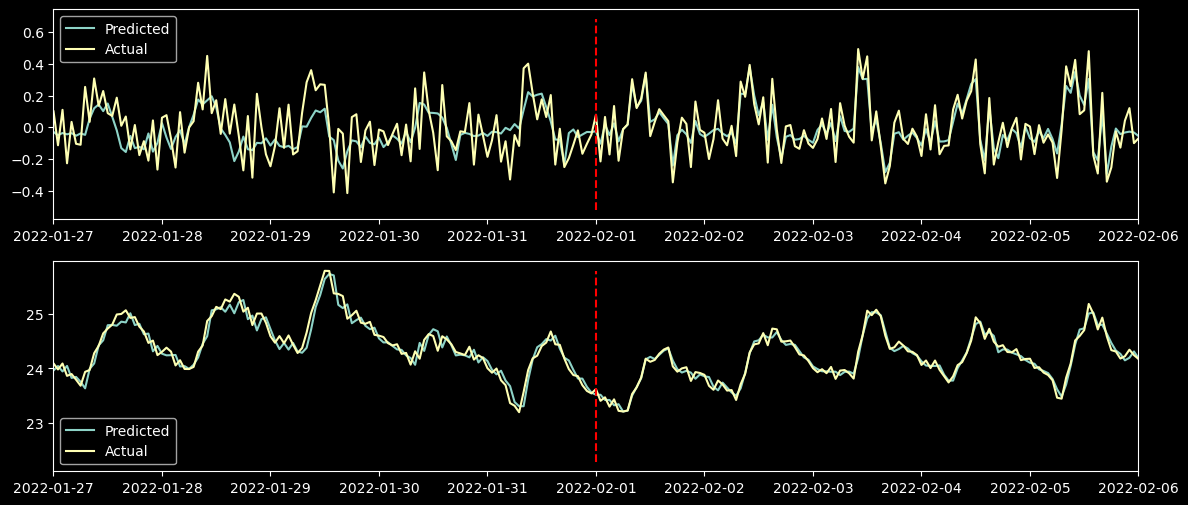

In [23]:
model_indoor = fit_and_test(XGBRegressor(
    n_estimators=20,
    learning_rate=0.2,
),
X_indoor, y_indoor)
model_indoor

(1178, 15) (717, 15)
train score:	 0.42935947558646337
test score:	 0.344405365194864

self RMSE:	 0.15640591250274763
pred RMSE:	 24.029894556684162
train RMSE:	 0.13813877366246108
test RMSE:	 0.14100422682918531

self RMSE:	 0.15640591250274763
pred RMSE:	 0.1213331521199437
train RMSE:	 0.11918479687425149
test RMSE:	 0.12477963962829798


SVR(C=0.1, kernel='linear')

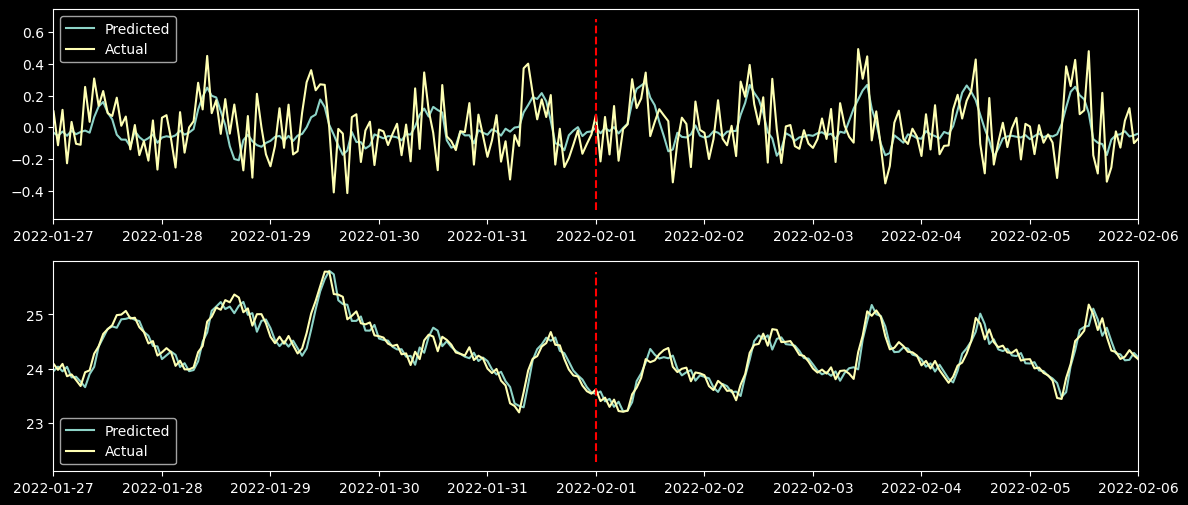

In [21]:
model_indoor = fit_and_test(SVR(kernel='linear', C=0.1), X_indoor, y_indoor)
model_indoor

(1178, 15) (717, 15)
train score:	 0.11082941725753803
test score:	 -0.8450266055482767

self RMSE:	 0.15640591250274763
pred RMSE:	 24.012361943341386
train RMSE:	 0.18877526239443573
test RMSE:	 0.18804128364602396

self RMSE:	 0.15640591250274763
pred RMSE:	 0.17419346744521888
train RMSE:	 0.14877771735394862
test RMSE:	 0.2093280116421201


MLPRegressor(hidden_layer_sizes=(64, 64, 64), random_state=42)

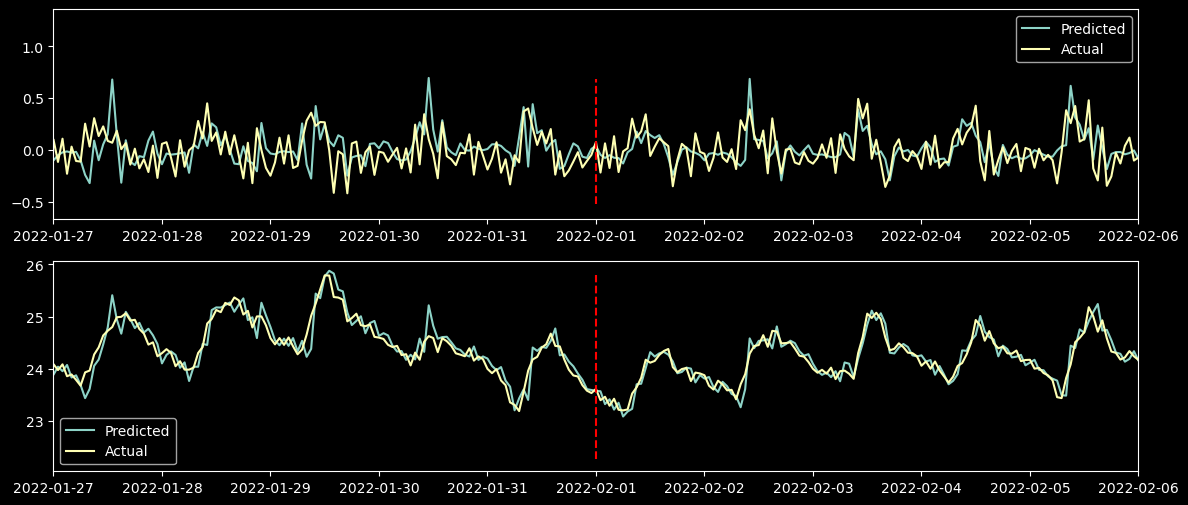

In [24]:
model_indoor = fit_and_test(MLPRegressor(
    hidden_layer_sizes=(64, 64, 64), 
    activation='relu',
    learning_rate='constant',
    learning_rate_init=0.001,
    random_state=42,
    # verbose=True,
    shuffle=True,
), X_indoor, y_indoor)
model_indoor

(1178, 15) (717, 15)
train score:	 0.43155290544980607
test score:	 0.3394256357577373

self RMSE:	 0.15640591250274763
pred RMSE:	 24.029892599031474
train RMSE:	 0.13901087626852074
test RMSE:	 0.1408674534724569

self RMSE:	 0.15640591250274763
pred RMSE:	 0.1213775390152205
train RMSE:	 0.11895506417200997
test RMSE:	 0.12525264026925495


{'sec_supp_t': -0.07444055159138058,
 'sec_supp_t_60min': -0.0453145049959714,
 'sec_supp_t_120min': 0.052434747958190586,
 'sec_supp_t_180min': 0.06162844068956295,
 'sec_back_t': 0.22534704151943885,
 'sec_back_t_60min': -0.08008839688955958,
 'sec_back_t_120min': -0.1329168283172053,
 'irradiance': 0.0002443191582163524,
 'irradiance_60min': 0.0009139379793458884,
 'irradiance_120min': -0.0008375212893201468,
 'indoor_60min': -0.14980145541934833,
 'indoor_120min': 0.09215580396395051,
 'outdoor': 0.01093764878353072,
 'outdoor_60min': -0.003275701704048949,
 'outdoor_120min': -0.0020584406003753635}

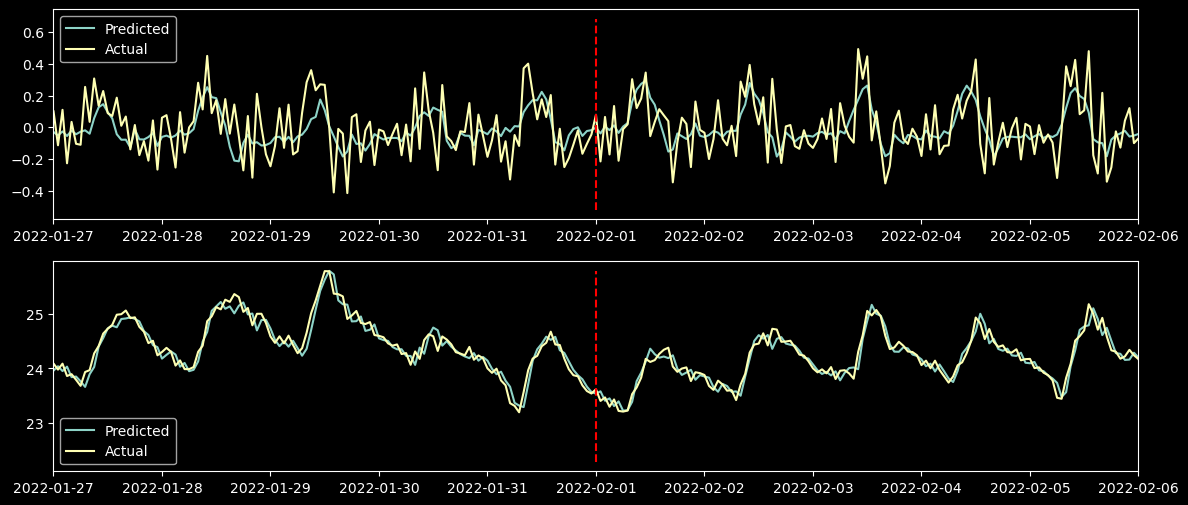

In [27]:
model_indoor = fit_and_test(LinearRegression(), X_indoor, y_indoor)

display(dict(zip(model_indoor.feature_names_in_, model_indoor.coef_)))
# significent = np.abs(model_indoor.coef_) > 1e-3
# display(dict(zip(model_indoor.feature_names_in_[significent], model_indoor.coef_[significent])))

(1178, 15) (717, 15)
train score:	 0.4294229145969428
test score:	 0.3395662491933189

self RMSE:	 0.15640591250274763
pred RMSE:	 24.029477674759598
train RMSE:	 0.13843106979628367
test RMSE:	 0.14088764873682755

self RMSE:	 0.15640591250274763
pred RMSE:	 0.121507848771939
train RMSE:	 0.11917748352618819
test RMSE:	 0.12523930858218502


c:\ProgramData\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.002e+00, tolerance: 2.930e-03
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.001, l1_ratio=0.01)

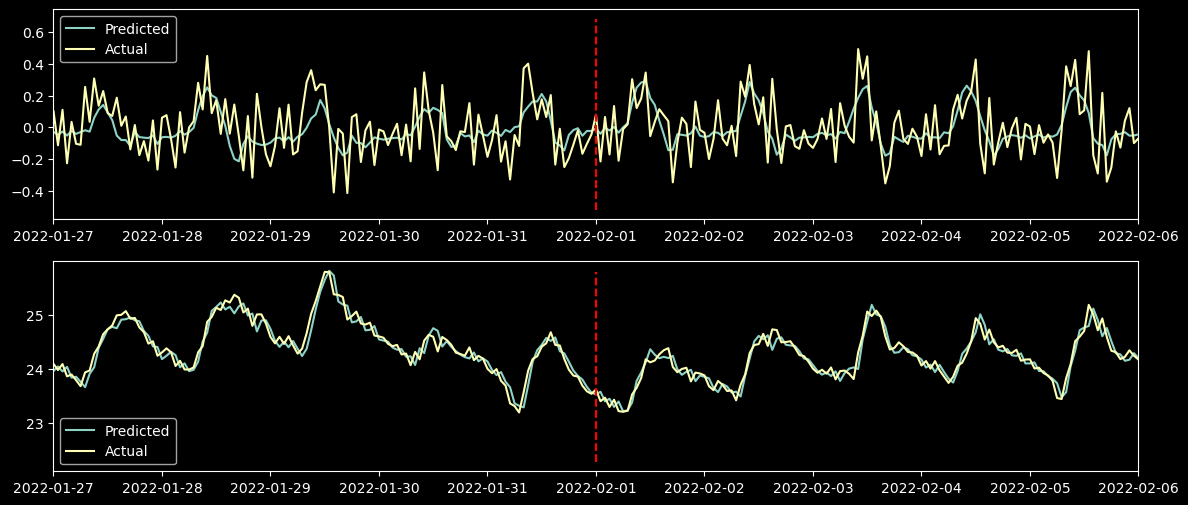

In [31]:
fit_and_test(ElasticNet(alpha=0.001, l1_ratio=0.01), X_indoor, y_indoor)

(1178, 15) (717, 15)
train score:	 0.5283039713745423
test score:	 0.2573095831406558

self RMSE:	 0.15640591250274763
pred RMSE:	 24.031742155091425
train RMSE:	 0.14112456041298935
test RMSE:	 0.14932069142411203

self RMSE:	 0.15640591250274763
pred RMSE:	 0.11821368387730839
train RMSE:	 0.10836273881200392
test RMSE:	 0.13280974465341916


KNeighborsRegressor()

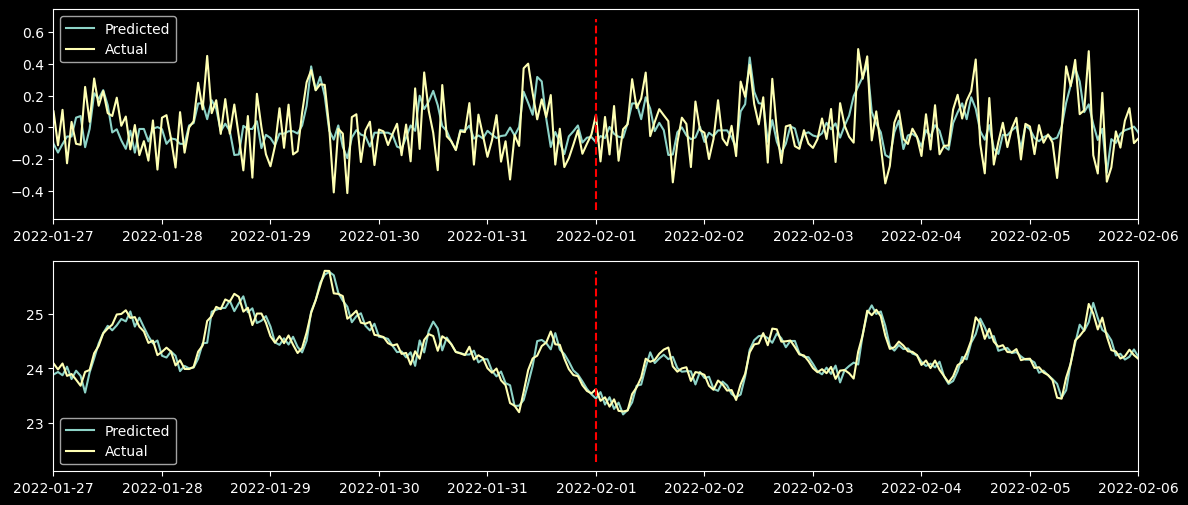

In [30]:
fit_and_test(KNeighborsRegressor(n_neighbors=5), X_indoor, y_indoor)

(1178, 15) (717, 15)
train score:	 0.4636417651409369
test score:	 0.3451417480620994

self RMSE:	 0.15640591250274763
pred RMSE:	 24.031289094488677
train RMSE:	 0.132210908817686
test RMSE:	 0.1365092414610247

self RMSE:	 0.15640591250274763
pred RMSE:	 0.11909847157133165
train RMSE:	 0.11554686830725047
test RMSE:	 0.12470954188758936


GradientBoostingRegressor(n_estimators=15)

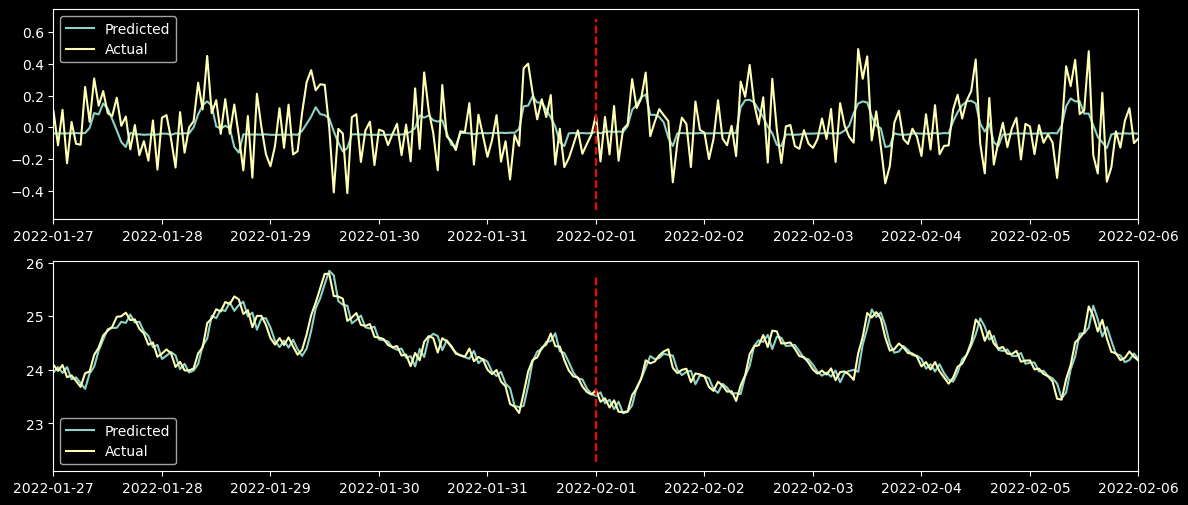

In [33]:
fit_and_test(GradientBoostingRegressor(n_estimators=15, learning_rate=0.1), X_indoor, y_indoor)

## Reinforcement Learning

In [ ]:
class Environment:

    State = pd.Series
    Action = float      # the increase or decrease of `sec_supp_t` per hour
    Reward = float


    def __init__(
            self, data: pd.DataFrame, pred_model: LinearRegression, start_time: pd.Timestamp
        ) -> None:
            self.data = data.copy()
            self.start_time = start_time.round('H')  # Round start_time to the nearest hour
            self.pred_model = pred_model

            self.X_cols: list[str] = pred_model.feature_names_in_

            self.reset()
            pass

    def reset(self) -> None:
        self.X = self.data.loc[:, self.X_cols].resample('H').mean()
        self.y = self.data['indoor'].resample('H').mean()
        self.S = self._get_initial_state()
        self.T = self.start_time
        self.X.loc[self.T:, 'indoor'] = np.nan
        pass

    def step(self, A: Action) -> tuple[State, Reward, bool]:
        # Apply the action to the environment
        # Return the next state, reward, done (whether the episode is finished), and additional info
        S_ = self._get_next_state(self.S, A)
        R = self._get_reward(self.S, A, S_)
        D = self._is_done(S_)
        self.S = S_
        self.T += pd.Timedelta('1H')
        self.X
        return S_, R, D

    def render(self) -> None:
        print(self.X.loc[self.T])

    def close(self) -> None:
        print('Close')

    #############################################################

    def _get_initial_state(self) -> State:
        return self.X.loc[self.start_time]

    def _get_next_state(self, S: State, A: Action) -> State:
        assert abs(A) <= 2
        T: pd.Timestamp = S.name
        S = S.copy()
        S['sec_supp_t'] += A
        S_ = self.X.loc[T + pd.Timedelta('1H')].copy()
        S_['indoor'] = self.pred_model.predict(S.values.reshape(1, -1))[0]
        return S_

    def _get_reward(self, S: State, A: Action, S_: State) -> Reward:
        R = S_['indoor'] - 22
        return R

    def _is_done(self, state: pd.Series) -> bool:
        T: pd.Timestamp = state.name
        return T >= self.X.index[-1]

In [798]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        return self.fc2(x)

class DQNAgent(pl.LightningModule):
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        super(DQNAgent, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.lr = lr

        self.q_network = QNetwork(state_size, action_size)
        self.memory = deque(maxlen=10000)
        self.batch_size = 64

    def forward(self, state):
        return self.q_network(state)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        return optimizer

    def act(self, state):
        if random.random() > self.epsilon:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.q_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)

        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

    def memory_replay(self):
        if len(self.memory) < self.batch_size:
            return
        experiences = random.sample(self.memory, self.batch_size)
        self.learn(experiences)

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
